In [ ]:
%%capture

# install required libraries
!pip3 install flashtext                  # easy phrase replacing methods
!pip3 install contractions               # expand English contractions 
!pip3 install --upgrade spacy==2.2.4     # functions for lemmatizing
!pip3 install gdown                      # download files from Google Drive
!pip3 install nltk                       # NLP library
!pip3 install wordcloud
!pip3 install ftfy
# conda install -c conda-forge spacy-model-en_core_web_sm
## https://anaconda.org/conda-forge/spacy-model-en_core_web_sm
## original github information of 'spacy' & 'en_core_web_sm' packages: https://github.com/explosion/spacy-models/releases?q=en_core_web_sm&expanded=true


In [3]:
# import libraries
import pandas as pd
import numpy as np
import gdown
import random
import string
import re
import random
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import unicodedata
import nltk
from nltk import SnowballStemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from ftfy import fix_text
from joblib import dump, load
import scipy.sparse
from gensim.corpora import Dictionary
#dictionary = Dictionary(stems)
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS

In [4]:
# contents of the invoked packages
stemmer = SnowballStemmer(language='english')
## Load English tokenizer, tagger, parser, NER and word vectors
nlp_standard = spacy.load('en_core_web_sm')
nltk.download('stopwords')
nltk.download('vader_lexicon')
# Initialize VADER
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Quincy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Quincy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# load the data an inspect it
data = pd.read_csv('reviews_bsample.csv')
print(data.shape)
data.head()

(66104, 38)


,rcid,company_id,company,review_id,review_language_id,location_raw,region,country,state,msa,...,review_summary,review_advice,review_pros,review_cons,review_count_helpful,review_count_not_helpful,ultimate_parent_rcid,ultimate_parent_company_name,review_date,review_time
0,75775,36982,The British Red Cross Society,63094119,eng,"London, England",Northern Europe,United Kingdom,England,london metropolitan area (united kingdom),...,BRC,NaN,"flexible working, reputable organisation, oppo...","can be quite disorganised, issues with management",1.0,NaN,75775.0,The British Red Cross Society,2022-04-21,10:49:05
1,6831823,618643,TriStar Centennial Medical Center,65255882,eng,NaN,empty,empty,empty,empty,...,Women and childrens residency,NaN,Great residency program depending on your unit,Very low pay with high turn over.,NaN,NaN,604422.0,"HCA Healthcare, Inc.",2022-06-08,6:38:46
2,724484,7036445,Odd Burger Corp.,61700338,eng,NaN,empty,empty,empty,empty,...,Fantastic Company with Huge Growth Potential,NaN,"Great leadership, well organized and lots of g...",Management has high expectations and it's not ...,NaN,NaN,724484.0,Odd Burger Corp.,2022-03-24,6:44:46
3,809141,7927,Infosys Ltd.,9589496,eng,NaN,empty,empty,empty,empty,...,great company,NaN,great company worked there for 5 years everyday.,had to leave due to personal problems,NaN,NaN,809141.0,Infosys Ltd.,2016-02-16,13:18:59
4,883558,1886918,T3 Security Ltd.,16603650,eng,NaN,empty,empty,empty,empty,...,Good,NaN,"10ph, nice locations, no trouble",None other than its nights,NaN,NaN,883558.0,T3 Security Ltd.,2017-08-31,4:36:37


In [6]:
data.dtypes

rcid                                  int64
company_id                            int64
company                              object
review_id                             int64
review_language_id                   object
location_raw                         object
region                               object
country                              object
state                                object
msa                                  object
job_title_raw                        object
mapped_role                          object
job_category                         object
review_iscovid19                       bool
reviewer_employment_status           object
reviewer_job_ending_year            float64
reviewer_length_of_employment       float64
reviewer_current_job                   bool
rating_overall                        int64
rating_business_outlook              object
rating_career_opportunities         float64
rating_ceo                           object
rating_compensation_and_benefits

In [7]:
df = data[['review_summary','review_advice','review_pros','review_cons','rating_compensation_and_benefits']]
df = df.copy()
df['review_summary'] = df['review_summary'].fillna('')
df['review_advice'] = df['review_advice'].fillna('')
df['review_pros'] = df['review_pros'].fillna('')
df['review_cons'] = df['review_cons'].fillna('')

df = df.astype({'review_summary':'string','review_advice':'string','review_pros':'string','review_cons':'string'})

df['review'] = df['review_summary'] + ' ' + df['review_advice'] + ' ' + df['review_pros'] + ' ' + df['review_cons']

df.head()

,review_summary,review_advice,review_pros,review_cons,rating_compensation_and_benefits,review
0,BRC,,"flexible working, reputable organisation, oppo...","can be quite disorganised, issues with management",NaN,"BRC flexible working, reputable organisation,..."
1,Women and childrens residency,,Great residency program depending on your unit,Very low pay with high turn over.,1.0,Women and childrens residency Great residency...
2,Fantastic Company with Huge Growth Potential,,"Great leadership, well organized and lots of g...",Management has high expectations and it's not ...,5.0,Fantastic Company with Huge Growth Potential ...
3,great company,,great company worked there for 5 years everyday.,had to leave due to personal problems,NaN,great company great company worked there for ...
4,Good,,"10ph, nice locations, no trouble",None other than its nights,5.0,"Good 10ph, nice locations, no trouble None ot..."


In [8]:
#Remove punctuation
string.punctuation
remv_punc = str.maketrans('','',string.punctuation)

In [9]:
# Call the translate function and make everything lower case
review_clean=[]
for review in df['review']:
    review = re.sub(r'[^a-zA-Z0-9\s]', '', review)
    review_fix = fix_text(review)
    review_nopunc = review_fix.translate(remv_punc).lower()
    review_clean.append(review_nopunc)
    
# tokenize with the spaCy tokenizer
def spacy_tokenizer_standard(sent):
    sent = nlp_standard.tokenizer(sent)
    tokens = [t.text for t in sent]
    return tokens

# apply function
tokens = list(map(spacy_tokenizer_standard, review_clean))
    
# remove non-ascii characters via unicodedata package
def remove_non_ascii(tokens):
    tokens = [unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in tokens]
    return tokens
    
# apply function
tokens = list(map(remove_non_ascii, tokens))

In [10]:
# remove stopwords via simple list comprehension
def remove_stopwords(tokens, stopwords):
    return [t for t in tokens if t not in stopwords]

# apply stopword removal function
tokens = list(map(lambda x: 
                  remove_stopwords(x, stopwords=stopwords.words("english")),
                  tokens))

# remove extra white spaces and short tokens via simple list comprehension
def remove_short(tokens, min_length=2):
    return [t.strip() for t in tokens if t.strip() != '' and len(t.strip()) > min_length] 

# apply function
tokens = list(map(remove_short, tokens))

In [11]:
# stem via standard nltk Snowball Stemmer
stemmer = SnowballStemmer(language='english')
def stem(tokens):
    """stem all tokens that do not contain hyphens"""
    return [stemmer.stem(t) if "-" not in t else t for t in tokens]

# apply function
stems = list(map(stem, tokens))

In [12]:
df['stems'] = stems

In [13]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

In [14]:
# generate document frequency ranking for all terms in the vocabulary
vectorizer = TfidfVectorizer(use_idf=False, norm=None, tokenizer=do_nothing, preprocessor=do_nothing) 
df_matrix = vectorizer.fit_transform(stems).toarray()
df_matrix_bool = np.where(df_matrix > 0, 1, 0)
scores_df = df_matrix_bool.sum(axis=0)

sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab_keys = list(np.array(sorted_vocab)[:,0])
sorted_scores_df = sorted(set(scores_df), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_df, list(range(len(sorted_scores_df))))}
rank_tup = sorted(zip(scores_df, sorted_vocab_keys),  key=lambda x: x[0], reverse=True)
df_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
df_ranking[:10]

## requires to allocate more virtual memory (e.g., 50GB) in the system setting to enable calculation

[(38395, 'work', 0),
 (26640, 'good', 1),
 (23552, 'great', 2),
 (20739, 'compani', 3),
 (19478, 'manag', 4),
 (15491, 'peopl', 5),
 (12358, 'employe', 6),
 (12119, 'place', 7),
 (11992, 'pay', 8),
 (11155, 'time', 9)]

In [15]:
# function to compute term-frequency inverse document frequency
def tf_idf_compute(term, num_docs, scores_tf, scores_df):
    return (1+np.log(scores_tf[term])*np.log(num_docs/scores_df[term]))

# generate term frequency inverse document frequency ranking for all terms in the vocabulary
sorted_vocab = sorted(vectorizer.vocabulary_.items(),   key=lambda x: x[1])
sorted_vocab = list(np.array(sorted_vocab)[:,0])
scores_tf = df_matrix.sum(axis=0)
scores_tfidf = [tf_idf_compute(t, len(tokens), scores_tf=scores_tf, scores_df=scores_df) for t in range(len(sorted_vocab))]
sorted_scores_tfidf = sorted(set(scores_tfidf), reverse=True)

rank_dict = {k:val for k,val in zip(sorted_scores_tfidf, list(range(len(sorted_scores_tfidf))))}
rank_tup = sorted(zip(scores_tfidf, sorted_vocab),  key=lambda x: x[0], reverse=True)
tfidf_ranking = [x + (rank_dict[x[0]],) for x in rank_tup]
tfidf_ranking[:10]

[(34.67421177477074, 'sbc', 0),
 (34.44752514270345, 'tutor', 1),
 (34.34989453817814, 'teacher', 2),
 (34.08727710132665, 'agent', 3),
 (33.97124358265153, 'driver', 4),
 (33.84237080595087, 'photo', 5),
 (33.77969436146272, 'district', 6),
 (33.65484811105667, 'contractor', 7),
 (33.651900658453364, 'rep', 8),
 (33.63601201363334, 'loan', 9)]

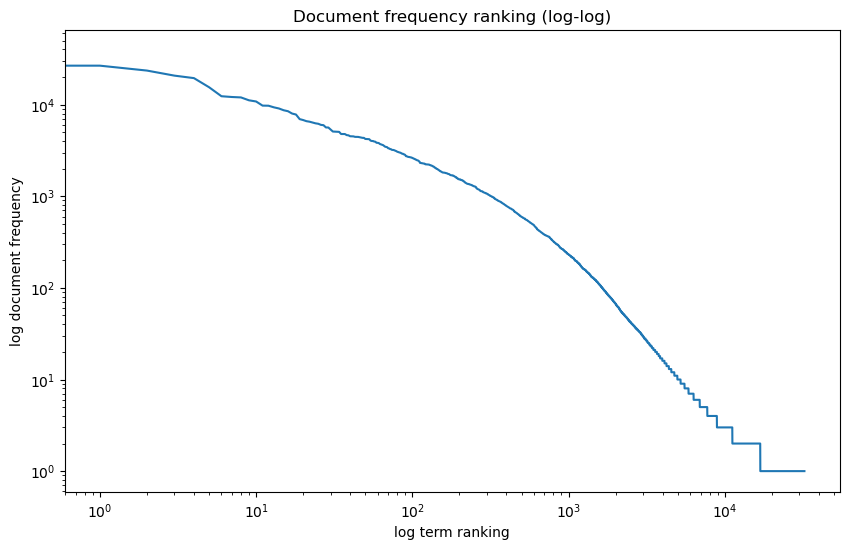

In [16]:
# plot document frequency

plt.figure(figsize=(10,6))
plt.loglog([x[0] for x in df_ranking])
plt.title('Document frequency ranking (log-log)')
plt.ylabel("log document frequency")
plt.xlabel("log term ranking")
plt.show()

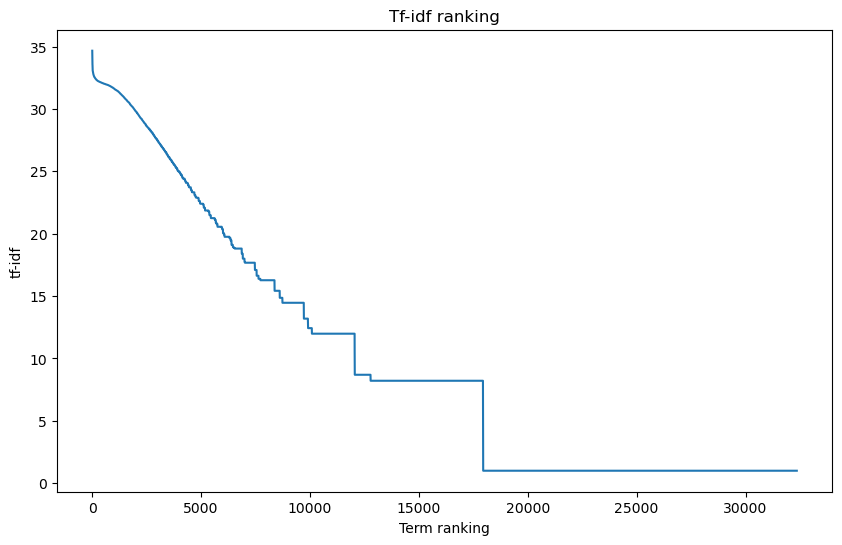

In [17]:
# plot tf-ids ranking
plt.figure(figsize=(10,6))
plt.plot([x[0] for x in tfidf_ranking])
plt.title('Tf-idf ranking')
plt.ylabel("tf-idf")
plt.xlabel("Term ranking")
plt.show()

In [18]:
# auxiliary function to easily remove undesired tokens
def remove(tokens, to_remove):
    if to_remove:
        return [t for t in tokens if t not in to_remove]
    else:
        return tokens

# function to remove tokens in documents according to their df or tfidf score 
def rank_remove(ranking, docs, min_cutoff_score=-np.inf, max_cutoff_score=np.inf):

    # define list of tokens to remove
    to_remove_low = set([t[1] for t in ranking if t[0] <= min_cutoff_score])
    to_remove_high = set([t[1] for t in ranking if t[0] > max_cutoff_score])

    # remove tokens
    docs_clean = [remove(d, to_remove_low) for d in docs]
    docs_clean = [remove(d, to_remove_high) for d in docs]

    return docs_clean

In [19]:
# update documents
stems_clean = rank_remove(tfidf_ranking, stems, min_cutoff_score=tfidf_ranking[12000][0])
tf_idf = vectorizer.fit_transform(stems_clean).toarray()

### LDA topic model

In [22]:
# Topic number
n_topics = 10
lda = LatentDirichletAllocation(
    n_components=n_topics, max_iter=50,
    learning_method='online',
    learning_offset=50.,
    random_state=0)
print(lda)

lda.fit(tf_idf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, random_state=0)


LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=50, random_state=0)

In [23]:
# store the calculation results

# Save the LDA model to a file
dump(lda, 'lda_model.joblib')

# Save the tf_idf matrix to a file
scipy.sparse.save_npz('tf_idf_matrix.npz', scipy.sparse.csr_matrix(tf_idf))

# Save the vectorizer
dump(vectorizer, 'tf_idf_vectorizer.joblib')

['tf_idf_vectorizer.joblib']

In [24]:
# explore the words with highest probability per topic
topics_dist = lda.components_
n_top_words = 20

# feature_names = vectorizer.get_feature_names()
feature_names = vectorizer.get_feature_names_out()
## choose one expression considering the different versions of the scikit-learn package

for i, topic_dist in enumerate(topics_dist):
    print("Topic #%d:" % i)
    print(" ".join([feature_names[i]
                    for i in topic_dist.argsort()[:-n_top_words - 1:-1]]))

Topic #0:
pay work hour manag good job time staff benefit flexibl schedul long get day employe custom low decent great shift
Topic #1:
work great place good compani peopl environ con realli team amaz friend noth best experi learn nice fun love lot
Topic #2:
commiss effici back center organis hospit downsid laid onlin smaller insid acquisit materi led cashier app warehous loan movement gas
Topic #3:
student school research teach teacher colleg administr wonder univers educ model campus signific citi local institut graduat live admin kid
Topic #4:
good work great compani salari balanc opportun environ life benefit place cultur manag learn career peopl pay project nice lot
Topic #5:
extrem remot awesom weekend patient daili shop annual worth door upon fulfil hectic per basi cloth crew emot warm quota
Topic #6:
review travel test natur fake mind box game relax incom troubl speed world confer monoton water cloud shadi investor messi
Topic #7:
compani team manag employe great work opportun p

In [25]:
# define a set of colors for each topic
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

# create a wordcloud object
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=n_top_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

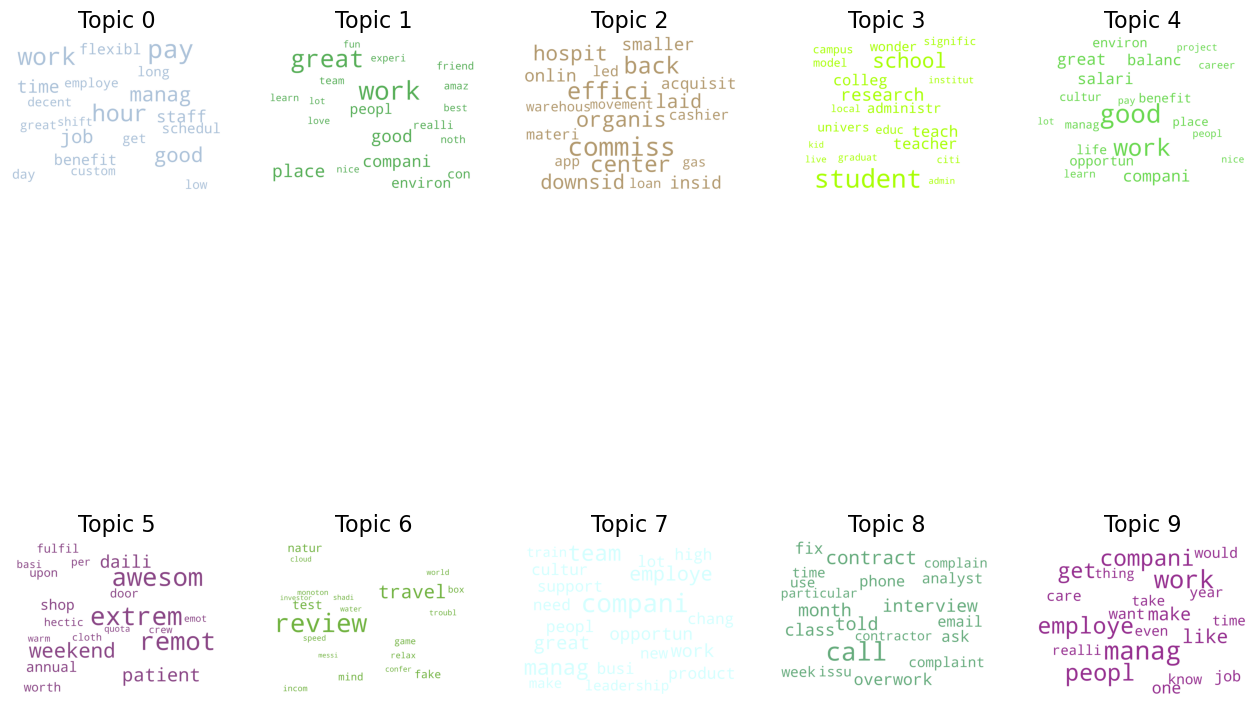

In [26]:
# create figure for the first 10 topics
fig, axes = plt.subplots(2, 5, figsize=(16,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    
    # select top words from topic
    topic_dist = lda.components_[i]
    top_idxs = np.argsort(topic_dist)[:-n_top_words - 1:-1]
    top_words = [feature_names[idx] for idx in top_idxs]
    top_probs = [topic_dist[idx] for idx in top_idxs]
    plot_dict = {top_words[i]:top_probs[i] for i in range(len(top_words))}

    # generate subplot    
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

In [27]:
# Improve Topic Detection (by finding better parameters in a subset and optimizing the model)

# Define the search parameters
search_params = {
    'n_components': [5, 10, 15, 20],  # Number of topics
    'learning_decay': [.5, .7, .9],   # Learning rate
}

# Subset the data for faster grid search
# For example, use 10% of the data for finding best parameters
tf_idf_subset, _ = train_test_split(tf_idf, test_size=0.9, random_state=42)

In [28]:
# Initialize the LDA model
lda_opt = LatentDirichletAllocation(max_iter=20,  # Low due to calculation capacity limit
                                learning_method='online',
                                random_state=0,
                                n_jobs=-1)  # Use all available CPUs

# Initialize the Grid Search class
model = GridSearchCV(lda_opt, param_grid=search_params)

# Perform the grid search on the subset of data
model.fit(tf_idf_subset)

# Output the best parameters
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(tf_idf))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 5}
Best Log Likelihood Score:  -294742.95414804015
Model Perplexity:  1377.0163877617836


In [29]:
# Now train the LDA model on the entire dataset using the best parameters
best_params = model.best_params_
lda_best = LatentDirichletAllocation(n_components=best_params['n_components'],
                                     learning_decay=best_params['learning_decay'],
                                     max_iter=10,  # Increase max_iter for better convergence
                                     learning_method='online',
                                     random_state=0)

lda_best.fit(tf_idf)  # Fit the LDA model on the entire dataset
# multi-process error due to memory limit: Could not pickle the task to send it to the workers

LatentDirichletAllocation(learning_decay=0.9, learning_method='online',
                          n_components=5, random_state=0)

In [30]:
dump(lda_best, 'lda_model_best.joblib')

['lda_model_best.joblib']

In [31]:
# explore the topics
topics_dist_best = lda_best.components_
n_top_words = 20

## choose one expression considering the different versions of the scikit-learn package

for i, topic_dist_best in enumerate(topics_dist_best):
    print("Topic #%d:" % i)
    print(" ".join([feature_names[i]
                    for i in topic_dist_best.argsort()[:-n_top_words - 1:-1]]))

Topic #0:
manag employe work compani peopl get make time staff like care need team one take year pay chang busi want
Topic #1:
work good great pay hour place manag environ compani job peopl nice benefit time flexibl salari friend low bad con
Topic #2:
job store stress get day free call end time month back custom favorit would food train wage respons patient much
Topic #3:
student enjoy school often posit live provid make research would help result depart differ experi work mani involv teach teacher
Topic #4:
work great good compani opportun cultur team balanc learn place lot peopl growth career environ life develop project experi grow


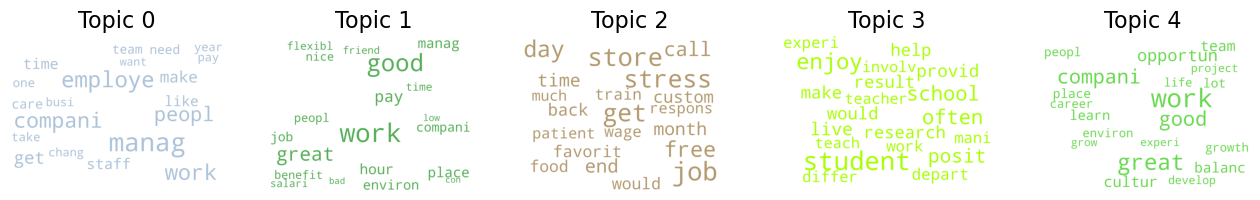

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(16,12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    
    # select top words from topic
    topic_dist_best = lda_best.components_[i]
    top_idxs_best = np.argsort(topic_dist_best)[:-n_top_words - 1:-1]
    top_words_best = [feature_names[idx] for idx in top_idxs_best]
    top_probs_best = [topic_dist_best[idx] for idx in top_idxs_best]
    plot_dict_best = {top_words_best[i]:top_probs_best[i] for i in range(len(top_words_best))}

    # generate subplot    
    fig.add_subplot(ax)
    cloud.generate_from_frequencies(plot_dict_best, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

### Topic correlation

In [33]:
# Get the topic distributions for the documents
topic_distributions = lda_best.transform(tf_idf)

In [34]:
# Convert to DataFrame
topics_df = pd.DataFrame(topic_distributions)

In [35]:
# Concatenate the topic distributions with the compensation ratings
compensation_df = pd.concat([topics_df, df['rating_compensation_and_benefits']], axis=1)

# Compute the correlation matrix
correlation_matrix = compensation_df.corr()

# Extract the correlations with the compensation column
compensation_correlation = correlation_matrix['rating_compensation_and_benefits'].drop('rating_compensation_and_benefits')

# Sort the correlations
sorted_correlation = compensation_correlation.sort_values(ascending=False)
print(sorted_correlation)

4    0.252409
1    0.078326
3    0.051312
2   -0.176063
0   -0.295976
Name: rating_compensation_and_benefits, dtype: float64


#### Machine learning: Word2Vec (Embedding)

In [36]:
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity

In [39]:
# Load a pre-trained Word2Vec model
## https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
## above is a 1.5G google pre-trained word2Vec model
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [40]:
# Extract the top keywords for each topic
top_keywords_by_topic = {}
for topic_idx in range(lda_best.n_components):
    topic_keywords = [feature_names[i] for i in lda_best.components_[topic_idx].argsort()[:-11:-1]]
    top_keywords_by_topic[topic_idx] = topic_keywords

In [41]:
# Define income-related terms
income_related_terms = ['income', 'wage', 'salary', 'pay', 'compensation']

# Function to create a vector for a cluster of words
def create_cluster_vector(words, word_vectors):
    valid_words = [word for word in words if word in word_vectors.key_to_index]
    if not valid_words:
        return None
    word_vecs = np.array([word_vectors[word] for word in valid_words])
    cluster_vec = np.mean(word_vecs, axis=0)
    return cluster_vec

# Create vector for the income-related cluster
income_vector = create_cluster_vector(income_related_terms, word_vectors)

In [42]:
# Measure similarity between the income-related vector and each topic vector
topic_similarity = {}
for topic_idx, keywords in top_keywords_by_topic.items():
    topic_vector = create_cluster_vector(keywords, word_vectors)
    if topic_vector is not None:
        similarity = cosine_similarity([income_vector], [topic_vector])[0][0]
        topic_similarity[topic_idx] = similarity

# Rank topics by their similarity to the income-related vector
ranked_topics = sorted(topic_similarity.items(), key=lambda item: item[1], reverse=True)

# Output the ranked topics and their similarities
for topic_idx, similarity in ranked_topics:
    print(f'Topic {topic_idx} is {similarity:.4f} similar to income-related terms')

Topic 1 is 0.4395 similar to income-related terms
Topic 0 is 0.3755 similar to income-related terms
Topic 2 is 0.3327 similar to income-related terms
Topic 3 is 0.2746 similar to income-related terms
Topic 4 is 0.2010 similar to income-related terms


### Extra - sentiment analysis

In [43]:
# Assign dominant topic & sentiments to each document
dominant_topic = np.argmax(topic_distributions, axis=1)
df['dominant_topic'] = dominant_topic

df['sentiments'] = df['review'].apply(lambda x: sid.polarity_scores(x))
df['sentiment_score'] = df['sentiments'].apply(lambda x: x['compound'])
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

In [ ]:
# Plot sentiment distribution
## note that modifications need to be made since the package version may mismatch
## specifically, change the 'mode.use_inf_as_null' to the 'mode.use_inf_as_na' in the relative '_core.py' script of the 'seaborn' package
sns.histplot(df['compound'], kde=False, bins=30)
plt.title('Sentiment Compound Score Distribution')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Number of Reviews')
plt.show()

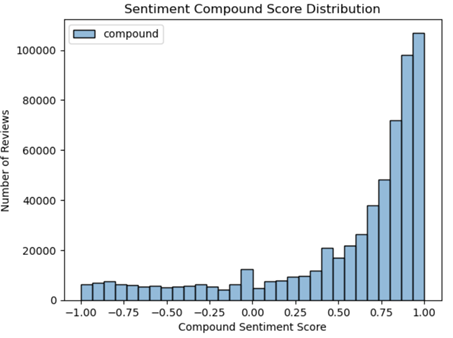

D:\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128 (\x80) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 153 (\x99) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


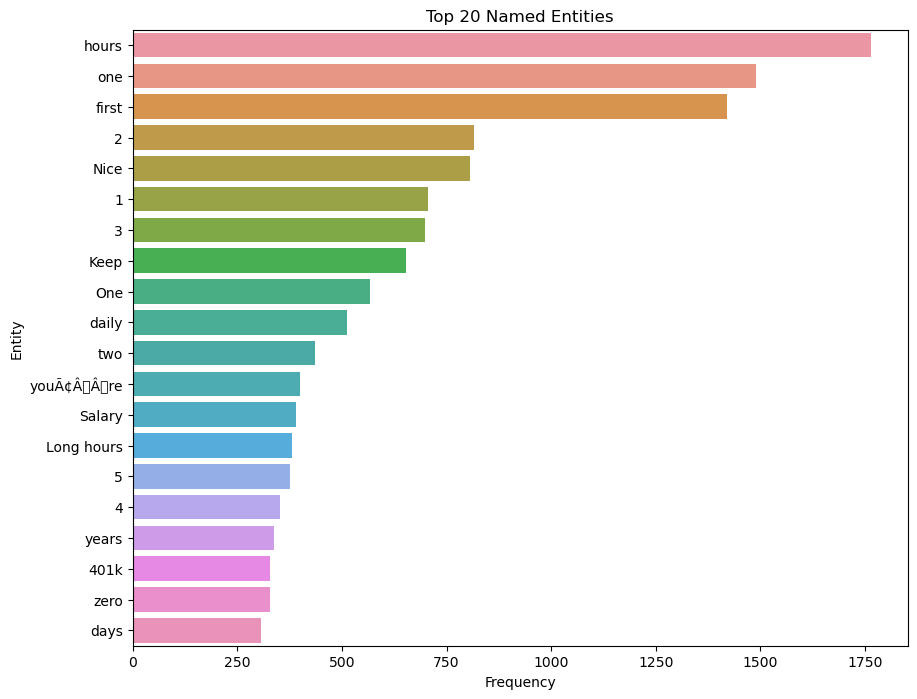

In [45]:
# Named Entity Recognition using spaCy
def extract_entities(text):
    doc = nlp_standard(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Apply NER to the reviews and create a new column for entities
df['entities'] = df['review'].apply(extract_entities)

# Explore the most common entities
all_entities = [ent for sublist in df['entities'].tolist() for ent in sublist]
entity_df = pd.DataFrame(all_entities, columns=['text', 'label'])

# Count the most common entities and plot
top_entities = entity_df['text'].value_counts().head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_entities.values, y=top_entities.index)
plt.title('Top 20 Named Entities')
plt.xlabel('Frequency')
plt.ylabel('Entity')
plt.show()

In [46]:
# Correlate sentiment scores with topic weights
for topic_idx in range(lda_best.n_components):
    correlation = np.corrcoef(df['sentiment_score'], topic_distributions[:, topic_idx])[0, 1]
    print(f'Correlation between sentiment scores and topic {topic_idx}: {correlation:.4f}')

Correlation between sentiment scores and topic 0: -0.2538
Correlation between sentiment scores and topic 1: 0.0651
Correlation between sentiment scores and topic 2: -0.1974
Correlation between sentiment scores and topic 3: 0.0268
Correlation between sentiment scores and topic 4: 0.2338


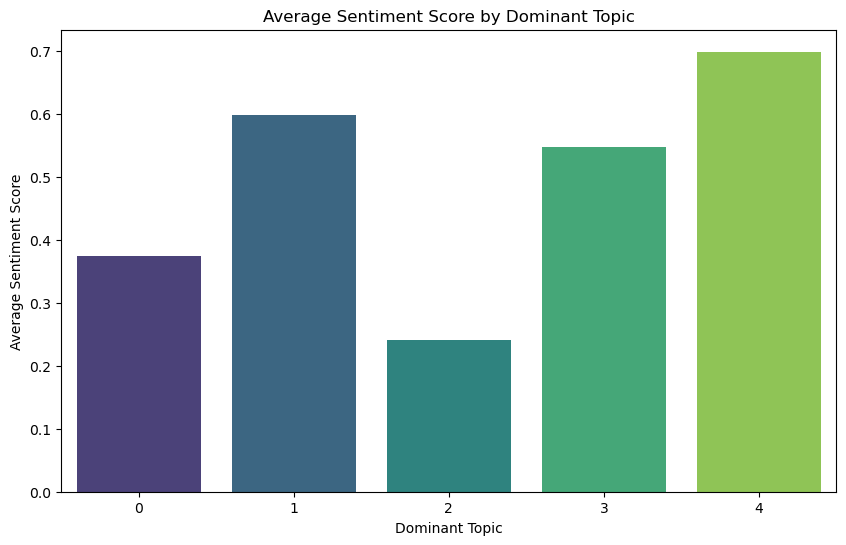

In [48]:
# how sentiments are distributed across different topics

# Group by dominant topic and calculate the average sentiment
topic_sentiment = df.groupby('dominant_topic')['compound'].mean().sort_values()

# Plot the average sentiment by topic
plt.figure(figsize=(10, 6))
sns.barplot(x=topic_sentiment.index, y=topic_sentiment.values, palette='viridis')
plt.title('Average Sentiment Score by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Average Sentiment Score')
plt.show()

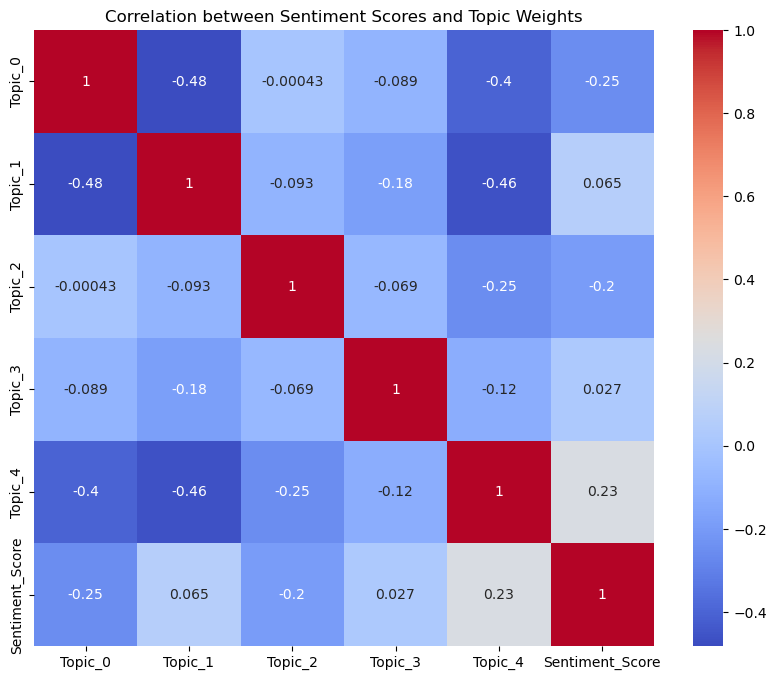

In [49]:
# visualize the correlation matrix using seaborn's heatmap
# Create a DataFrame for the topic distributions
topic_df = pd.DataFrame(topic_distributions, columns=[f'Topic_{i}' for i in range(lda_best.n_components)])
# Add sentiment scores to the DataFrame
topic_df['Sentiment_Score'] = df['sentiment_score']

# Calculate the correlation matrix
correlation_matrix = topic_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Sentiment Scores and Topic Weights')
plt.show()